# Generating complex meshes with an existing boundary

This notebook shows how to generate complex meshes from shapefile data of an existing boundary. For us to generate meshes we first need to know where in space the study area is; this can be accomplished by having a basin boundary shapefile, or in this case using a DEM to find a gage location and then pulling the drainage area that contributes to the gage from USGS Streamstats.

In [1]:
import dany
import flopy
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import pathlib as pl
import dataretrieval.nwis as nwis
from dataretrieval import nldi
from pyproj import Transformer

import warnings
warnings.simplefilter("ignore", DeprecationWarning)

### Load the study area raster

This example uses FloPy's raster class to load a Digital Elevation Model (DEM) that covers the Sagehen Creek Watershed area

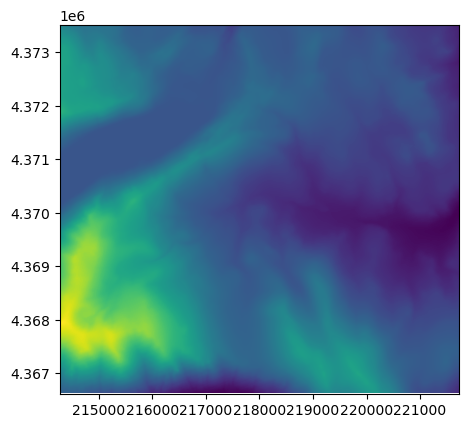

In [2]:
raster = pl.Path("../data/dem.img")
rstr = flopy.utils.Raster.load(raster)
rstr.plot();

## Pulling the watershed boundary from USGS streamstats

The first step in this process is to use the `dataretrieval` package get USGS stream gage locations from NWIS. We can then use gage locations to get a polygon that defines the upslope watershed area for our study area. 

We will need to reproject our raster boundary from UTM NAD83 Zone 11N into decimal latitude and longitude for the `dataretrieval` api call

In [3]:
epsg_utm = rstr._meta['crs'].to_epsg()
epsg_wgs84 = 4326
crs_utm = f"EPSG:{epsg_utm}"
crs_wgs84 = f"EPSG:{epsg_wgs84}"

transformer = Transformer.from_crs(crs_utm, crs_wgs84, always_xy=True)

In [4]:
xmin, xmax, ymin, ymax = rstr.bounds

xmin, ymin = transformer.transform(xmin, ymin)
xmax, ymax = transformer.transform(xmax, ymax)
wgs_bounds = [xmin, ymin, xmax, ymax]

And now to get station locations using `dataretrieval`

In [5]:
info, meta = nwis.get_info(bBox=[f"{i :.2f}" for i in wgs_bounds])
# geoms = gpd.points_from_xy(info.dec_long_va.values, info.dec_lat_va.values)
# info = gpd.GeoDataFrame(info, geometry=geoms, crs=f"EPSG:{epsg_wgs84}")
info.to_crs(epsg=epsg_utm, inplace=True)

In [6]:
info.head()

,agency_cd,site_no,station_nm,site_tp_cd,lat_va,long_va,dec_lat_va,dec_long_va,coord_meth_cd,coord_acy_cd,...,reliability_cd,gw_file_cd,nat_aqfr_cd,aqfr_cd,aqfr_type_cd,well_depth_va,hole_depth_va,depth_src_cd,project_no,geometry
0,USGS,10342900,INDEPENDENCE LK NR TRUCKEE CA,LK,392707.0,1201723.00,39.451849,-120.290759,M,F,...,NaN,NNNNNNNN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (216838.412 4372090.976)
1,USGS,10343000,INDEPENDENCE C NR TRUCKEE CA,ST,392724.0,1201710.00,39.456572,-120.287148,M,F,...,NaN,NNNNNNNN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (217168.338 4372603.864)
2,USGS,10343500,SAGEHEN C NR TRUCKEE CA,ST,392554.0,1201413.00,39.431572,-120.237979,M,F,...,NaN,NNNNNNNN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (221299.997 4369675.311)
3,USGS,392501120182800,SAGEHEN CR NR CARPENTER RIDGE CA,ST,392501.0,1201828.00,39.416849,-120.308814,M,S,...,NaN,NNNNNNNN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (215141.782 4368262.355)
4,USGS,392553120142301,NADP NTN CA50 A SAGEHEN CREEK NR TRUCKEE CA,AT,392553.4,1201422.92,39.431500,-120.239700,M,M,...,U,Y,NaN,NaN,NaN,NaN,NaN,NaN,NADP,POINT (221151.573 4369672.591)


Plotting up gage locations on the raster

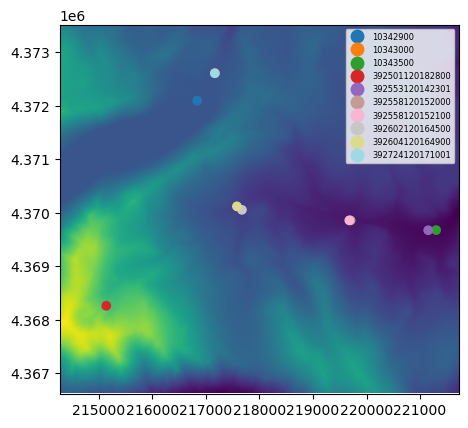

In [7]:
fig, ax = plt.subplots()

raster = pl.Path("../data/dem.img")
rstr = flopy.utils.Raster.load(raster)
rstr.plot(ax=ax)
info.plot(column="site_no", ax=ax, cmap="tab20", legend=True, legend_kwds={"fontsize":6});

Grab the site record for gage number 10343500

In [8]:
sitedf = info.loc[info.site_no == "10343500"]
sitedf

,agency_cd,site_no,station_nm,site_tp_cd,lat_va,long_va,dec_lat_va,dec_long_va,coord_meth_cd,coord_acy_cd,...,reliability_cd,gw_file_cd,nat_aqfr_cd,aqfr_cd,aqfr_type_cd,well_depth_va,hole_depth_va,depth_src_cd,project_no,geometry
2,USGS,10343500,SAGEHEN C NR TRUCKEE CA,ST,392554.0,1201413.0,39.431572,-120.237979,M,F,...,NaN,NNNNNNNN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (221299.997 4369675.311)


Get the upstream basin from nldi using the NWIS stream gage station code

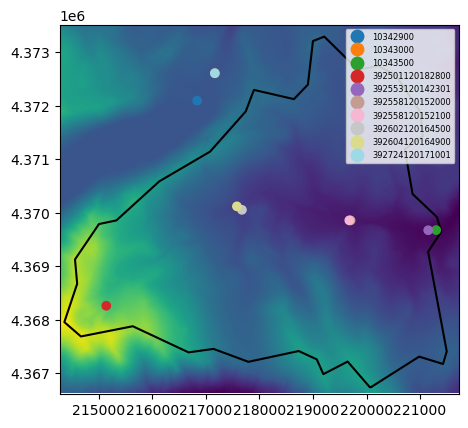

In [9]:
basindf = nldi.get_basin(feature_source="nwissite", feature_id=f"USGS-{sitedf.site_no.values[0]}")
basindf = basindf.to_crs(epsg=epsg_utm)

fig, ax = plt.subplots()
rstr.plot(ax=ax)
basindf.plot(ax=ax, facecolor="None", edgecolor="k", lw=1.5)
info.plot(column="site_no", ax=ax, cmap="tab20", legend=True, legend_kwds={"fontsize":6});

We can also get the NHD streamlines using dataretrieval

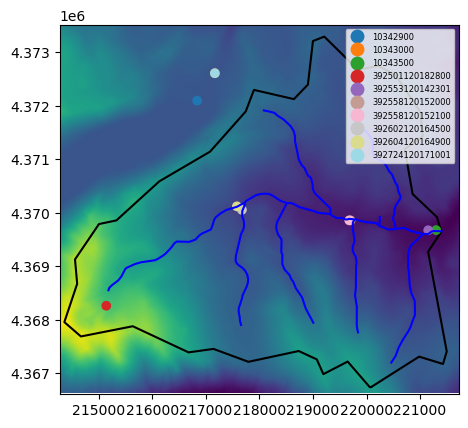

In [12]:
nhddf = nldi.get_flowlines(
    navigation_mode="UT", 
    distance=999, 
    feature_source="nwissite", 
    feature_id=f"USGS-{sitedf.site_no.values[0]}"
)
nhddf = nhddf.to_crs(epsg=epsg_utm)

fig, ax = plt.subplots()
rstr.plot(ax=ax)
basindf.plot(ax=ax, facecolor="None", edgecolor="k", lw=1.5)
nhddf.plot(ax=ax, edgecolor="b", lw=1.5)
info.plot(column="site_no", ax=ax, cmap="tab20", legend=True, legend_kwds={"fontsize":6});